In [1]:
import os
import sys
import pickle
import time

from copy import deepcopy

from cnp.experiment import WorkingDirectory

from cnp.cnp import GaussianNeuralProcess, StandardConvGNP
from cnp.lnp import StandardConvNP
from cnp.architectures import UNet

from cnp.cov import (
    OutputLayer,
    MeanFieldGaussianLayer,
    InnerprodGaussianLayer,
    KvvGaussianLayer,
    LogLogitCopulaLayer,
    ExponentialCopulaLayer
)

import numpy as np
import matplotlib.pyplot as plt

import torch

from cnp.encoders import (
    StandardEncoder,
    ConvEncoder,
    ConvPDEncoder,
)

from cnp.decoders import (
    StandardDecoder,
    ConvDecoder,
    ConvPDDecoder,
)

import torch
import torch.nn as nn

from torch.distributions import (
    Normal,
    MultivariateNormal,
    LowRankMultivariateNormal
)

from cnp.cov import GaussianLayer

In [2]:
args_data = 'sim-pred-prey-16-50-100-100-0' # 'sim-pred-prey-16-50-100-100-0'
args_cov_type = 'kvv'
args_noise_type = 'homo'
args_marginal_type = 'exponential'
args_model = 'convGNP'
args_num_basis_dim = 32

args_seed = 0
args_learning_rate = 5e-4
args_weight_decay = 0.
args_validate_every = 1
args_jitter = 1e-4

In [3]:
# Set seed
np.random.seed(args_seed)
torch.manual_seed(args_seed)

# root = '/Users/stratis/repos/kernelcnp/kernelcnp/experiments/predator-prey'
root = '/scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey'

# Working directory for saving results
experiment_name = os.path.join(f'{root}',
                               f'results',
                               f'{args_data}',
                               f'models',
                               f'{args_model}',
                               f'{args_cov_type}',
                               f'{args_noise_type}',
                               f'{args_marginal_type}',
                               f'seed-{args_seed}')
working_directory = WorkingDirectory(root=experiment_name)

# Data directory for loading data
data_root = os.path.join(f'{root}',
                         f'simulated-data',
                         f'{args_data}')
data_directory = WorkingDirectory(root=data_root)
    
file = open(working_directory.file('data_location.txt'), 'w')
file.write(data_directory.root)
file.close()

# =============================================================================
# Load data and validation oracle generator
# =============================================================================
    
file = open(data_directory.file('train-data.pkl'), 'rb')
data_train = pickle.load(file)
file.close()

file = open(data_directory.file('valid-data.pkl'), 'rb')
data_val = pickle.load(file)
file.close()

Root: /scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey/results/sim-pred-prey-16-50-100-100-0/models/convGNP/kvv/homo/exponential/seed-0
Root: /scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey/simulated-data/sim-pred-prey-16-50-100-100-0


In [4]:
# =============================================================================
# Training epoch helper
# =============================================================================

def train(data,
          model,
          optimiser,
          log_every,
          device,
          writer,
          iteration):
    
    for step, batch in enumerate(data):

        nll = model.loss(batch['x_context'][:, :, None].to(device),
                         batch['y_context'][:, 0, :, None].to(device) / 100 + 1e-2,
                         batch['x_target'][:, :, None].to(device),
                         batch['y_target'][:, 0, :, None].to(device) / 100 + 1e-2)
        
        encoder_scale = torch.exp(model.encoder.sigma).detach().cpu().numpy().squeeze()
        decoder_scale = torch.exp(model.decoder.sigma).detach().cpu().numpy().squeeze()

        if step % log_every == 0:
            print(f"Training   neg. log-lik: {nll:.2f}, "
                  f"Encoder/decoder scales {encoder_scale:.3f} "
                  f"{decoder_scale:.3f}")

        # Compute gradients and apply them
        nll.backward()
        optimiser.step()
        optimiser.zero_grad()

#         # Write to tensorboard
#         writer.add_scalar('Train log-lik.', - nll, iteration)
        
        iteration = iteration + 1
        
    return iteration


# =============================================================================
# Validation helper
# =============================================================================


def validate(data,
             model,
             device,
             writer,
             latent_model):
    
    # Lists for logging model's training NLL and oracle NLL
    nll_list = []
    oracle_nll_list = []
    
    # If training a latent model, set the number of latent samples accordingly
    loss_kwargs = {'num_samples' : args_np_val_samples} \
                  if latent_model else {}
    
    with torch.no_grad():
        for step, batch in enumerate(data):
            
            print(batch['x_context'].shape,
                  batch['y_context'].shape,
                  batch['x_target'].shape,
                  batch['y_target'].shape)
            
            nll = model.loss(batch['x_context'][:, :, None].to(device),
                             batch['y_context'][:, 0, :, None].to(device) / 100 + 1e-2,
                             batch['x_target'][:, :, None].to(device),
                             batch['y_target'][:, 0, :, None].to(device) / 100 + 1e-2,
                             **loss_kwargs)
            
            # Scale by the average number of target points
            nll_list.append(nll.item())

    mean_nll = np.mean(nll_list)
    std_nll = np.var(nll_list)**0.5

    # Print validation loss and oracle loss
    print(f"Validation neg. log-lik: "
          f"{mean_nll:.2f}")

    return mean_nll, std_nll

In [53]:
class StandardConvGNP(GaussianNeuralProcess):
    
    def __init__(self, input_dim, output_layer):
        
        # Standard input/output dimensions and discretisation density
        output_dim = 1
        points_per_unit = 32

        conv_channels = 8
        conv_in_channels = conv_channels
        conv_out_channels = 8
        
        # Standard convolutional architecture
        conv_architecture = UNet(input_dim=input_dim,
                                 in_channels=conv_in_channels,
                                 out_channels=conv_out_channels)

        # Construct the convolutional encoder
        grid_multiplyer =  2 ** conv_architecture.num_halving_layers
        encoder_init_length_scale = 5e-1 # 1.0 / points_per_unit
        decoder_init_length_scale = 5e-1 # 1.0 / points_per_unit
        grid_margin = 5.
        
        encoder = ConvEncoder(input_dim=input_dim,
                              out_channels=conv_channels,
                              init_length_scale=encoder_init_length_scale,
                              points_per_unit=points_per_unit,
                              grid_multiplier=grid_multiplyer,
                              grid_margin=grid_margin)
        
        # Construct the convolutional decoder
        decoder_out_channels = output_layer.num_features
        
        decoder = ConvDecoder(input_dim=input_dim,
                              conv_architecture=conv_architecture,
                              conv_out_channels=conv_architecture.out_channels,
                              out_channels=decoder_out_channels,
                              init_length_scale=decoder_init_length_scale,
                              points_per_unit=points_per_unit,
                              grid_multiplier=grid_multiplyer,
                              grid_margin=grid_margin)


        super().__init__(encoder=encoder,
                         decoder=decoder,
                         output_layer=output_layer)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.conv_architecture = conv_architecture

In [54]:
# =============================================================================
# Create model
# =============================================================================
    
# Set device
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    
use_cpu = False
device = torch.device('cpu') if use_cpu else torch.device('cuda')

cov_types = {
    'meanfield' : MeanFieldGaussianLayer,
    'innerprod' : InnerprodGaussianLayer,
    'kvv'       : KvvGaussianLayer
}

if args_cov_type == 'meanfield':
    output_layer = MeanFieldGaussianLayer(jitter=args_jitter,
                                          constrain_variance=False)
    
else:
    output_layer = cov_types[args_cov_type](num_embedding=args_num_basis_dim,
                                            noise_type=args_noise_type,
                                            jitter=args_jitter)

if args_marginal_type == 'loglogit':
    output_layer = LogLogitCopulaLayer(gaussian_layer=output_layer,
                                       device=device)
if args_marginal_type == 'exponential':
    output_layer = ExponentialCopulaLayer(gaussian_layer=output_layer,
                                          device=device)
    
# Create model architecture
if args_model == 'convGNP':
    model = StandardConvGNP(input_dim=1, output_layer=output_layer)
    
elif args_model == 'convNP':
    model = StandardConvNP(input_dim=1,
                           num_samples=args_np_loss_samples)
    
else:
    raise ValueError(f'Unknown model {args_model}.')

model.to(device)

latent_model = args_model == 'convNP'

print(f'{args_data} '
      f'{args_model} '
      f'{args_cov_type} '
      f'{args_noise_type} '
      f'{args_marginal_type} '
      f'{args_num_basis_dim}: '
      f'{model.num_params}')

sim-pred-prey-16-50-100-100-0 convGNP kvv homo exponential 32: 50999.0


In [55]:
# =============================================================================
# Train or test model
# =============================================================================

# Number of epochs between validations
train_iteration = 0
log_every = 100

# Create optimiser
optimiser = torch.optim.Adam(model.parameters(),
                         args_learning_rate,
                         weight_decay=args_weight_decay)

# Run the training loop, maintaining the best objective value
best_nll = np.inf

epochs = len(data_train)

start_time = time.time()
for epoch in range(epochs):

    print('\nEpoch: {}/{}'.format(epoch+1, epochs))

    if False: # epoch % args_validate_every == 0:

        valid_epoch = data_val[epoch // args_validate_every]

        # Compute negative log-likelihood on validation data
        val_nll, _,  = validate(valid_epoch,
                                model,
                                device,
                                None,
                                latent_model)

#         # Log information to tensorboard
#         writer.add_scalar('True data log-lik.',
#                           -true_nll,
#                           epoch)

#         # Log information to tensorboard
#         writer.add_scalar('Validation log-lik.',
#                           -val_nll,
#                           epoch)

        # Update the best objective value and checkpoint the model
        is_best, best_obj = (True, val_nll) if val_nll < best_nll else \
                            (False, best_nll)


    train_epoch = data_train[epoch]

    # Compute training negative log-likelihood
    train_iteration = train(train_epoch,
                            model,
                            optimiser,
                            log_every,
                            device,
                            None,
                            train_iteration)

#     save_checkpoint(working_directory,
#                     {'epoch'         : epoch + 1,
#                      'state_dict'    : model.state_dict(),
#                      'best_acc_top1' : best_obj,
#                      'optimizer'     : optimiser.state_dict()},
#                     is_best=is_best,
#                     epoch=epoch)


Epoch: 1/101
Training   neg. log-lik: 207.05, Encoder/decoder scales 0.500 0.500
Training   neg. log-lik: 109.83, Encoder/decoder scales 0.486 0.482
Training   neg. log-lik: 114.45, Encoder/decoder scales 0.482 0.476
Training   neg. log-lik: 83.92, Encoder/decoder scales 0.477 0.474
Training   neg. log-lik: 113.28, Encoder/decoder scales 0.470 0.472
Training   neg. log-lik: 114.17, Encoder/decoder scales 0.464 0.471
Training   neg. log-lik: 102.07, Encoder/decoder scales 0.459 0.470
Training   neg. log-lik: 121.78, Encoder/decoder scales 0.455 0.470
Training   neg. log-lik: 93.11, Encoder/decoder scales 0.444 0.466
Training   neg. log-lik: 121.34, Encoder/decoder scales 0.440 0.465
Training   neg. log-lik: 83.19, Encoder/decoder scales 0.436 0.465

Epoch: 2/101
Training   neg. log-lik: 95.62, Encoder/decoder scales 0.435 0.464
Training   neg. log-lik: 97.20, Encoder/decoder scales 0.431 0.463
Training   neg. log-lik: 95.11, Encoder/decoder scales 0.426 0.462
Training   neg. log-lik: 1

KeyboardInterrupt: 

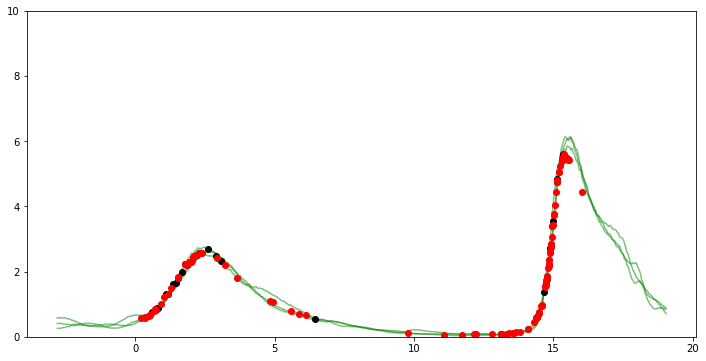

In [62]:
e_idx = 70
i_idx = 5
b_idx = 0

train_epoch = data_train[e_idx]

x_min = torch.min(train_epoch[i_idx]['x_target'][b_idx, :])
x_max = torch.max(train_epoch[i_idx]['x_target'][b_idx, :])
x_plot = torch.linspace(x_min-3., x_max+3., 500)[None, :, None].to(device)
x_plot = x_plot.repeat(train_epoch[i_idx]['x_context'].shape[0], 1, 1).to(device)

x_ctx = train_epoch[i_idx]['x_context']
y_ctx = train_epoch[i_idx]['y_context']

with torch.no_grad():
    samples = [model.sample(x_ctx[:, :, None].to(device),
                            y_ctx[:, 0, :, None].to(device) / 100 + 1e-2,
                            x_plot,
                            num_samples=3,
                            noiseless=True,
                            double=True)
               for i in range(1)]
    samples = torch.cat(samples, dim=0)

plt.figure(figsize=(12, 6))
plt.plot(x_plot[0, :, 0].cpu().detach().numpy(),
         samples[:, b_idx, :].cpu().detach().numpy().T,
         color='green',
         alpha=0.5,
         zorder=1)

# plt.plot(x_plot[0, :, 0].cpu().detach().numpy(),
#          torch.mean(samples[:, b_idx, :], axis=0).cpu().detach().numpy().T,
#          color='black',
#          alpha=0.5,
#          zorder=2)

plt.scatter(x_ctx[b_idx, :].detach().numpy(),
            y_ctx[b_idx, 0, :].detach().numpy() / 100,
            color='black',
            zorder=2)

# plt.scatter(train_epoch[i_idx]['x_context'][b_idx, max_ctx:].detach().numpy(),
#             train_epoch[i_idx]['y_context'][b_idx, 0, max_ctx:].detach().numpy() / 100,
#             color='red',
#             zorder=2)

plt.scatter(train_epoch[i_idx]['x_target'][b_idx, :].detach().numpy(),
            train_epoch[i_idx]['y_target'][b_idx, 0, :].detach().numpy() / 100,
            color='red',
            zorder=2)

plt.ylim([0, 10])
plt.show()